In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Import TensorFlow
import tensorflow as tf
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.initializers import lecun_uniform

from scripts_ml.ann_utils import *

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13837990283221700283
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1449056665
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10804198425164244597
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [9]:
#importing data
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
prefix_time_seq = 'time_2018-04-30_p90_bg_'
valid_code = '_val_24000_6000_'
trainfile = '_traindata'
testfile = '_testdata'
postfix_time_seq_val = '_190824_1253'
postfix_time_seq = '_190824_1230'
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
indexfile = '_fold_indexes'
expname = "RNN_"+preproc_folder+valid_code.split('_val_')[1][:-1]+"_opt_p90"

[X_train, y_train, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+trainfile+postfix_time_seq+'.pkl') 
[X_test, y_test, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+testfile+postfix_time_seq+'.pkl') 
[val_X_train, val_y_train, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+trainfile+postfix_time_seq_val+'.pkl') 
[val_X_test, val_y_test, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+testfile+postfix_time_seq_val+'.pkl') 
indexes = pd.read_pickle(datafolder+prefix_time_seq+valid_code+indexfile+postfix_time_seq_val+'.pkl')

In [10]:
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Bidirectional, Flatten, GRU, BatchNormalization
from tensorflow.keras.models import Sequential

In [11]:
fold = int(valid_code.split('_val_')[1].split('_')[0])

In [12]:
#recombining folds for grid search

val_X_tr = []
val_y_tr = []
val_X_tst = []
val_y_tst = []
indexes_tuples = []

count=0
start_tr=0

for idx in indexes:
    val_X_tr.append(list(val_X_train[idx[0][-fold:]]))
    val_y_tr.append(list(val_y_train[idx[0][-fold:]]))
    if count==0:
        test_idx = np.array(range(0, len(idx[1])))
    else:
        test_idx+=len(idx[1])
    val_X_tst.append(list(val_X_test[test_idx]))
    val_y_tst.append(list(val_y_test[test_idx]))
    
    
    if count==0:
        start_tst = len(idx[0])
    else:
        start_tr+=add_to_tr
        start_tst=start_tr+len(idx[0])
        
    indexes_tuples.append((np.array(range(start_tr, start_tr+len(idx[0]))), 
                          np.array(range(start_tst, start_tst+len(idx[1])))))
    
    add_to_tr = len(idx[0])+len(idx[1])
    
    count+=1

In [13]:
X = np.array(val_X_tr)
X=X.reshape((X.shape[1], X.shape[0], X.shape[2]))
#y = np.array([val_X_all[1]])


In [14]:
y = np.array(val_y_tr)
y = y.reshape((X.shape[0], X.shape[1],1))
y.shape

(24000, 3, 1)

In [15]:
X_val = np.array(val_X_tst)
X_val = X_val.reshape((X_val.shape[1], X_val.shape[0], X_val.shape[2]))

In [16]:
y_val = np.array(val_y_tst)
y_val = y_val.reshape((X_val.shape[0], X_val.shape[1],1))

In [17]:
from sklearn.utils import class_weight

#class_weights = class_weight.compute_class_weight('balanced',
#                                                 np.unique(y_val),
#                                                 y_train)

cw = class_weight.compute_sample_weight({False:1, True:50},#'balanced',
                                                 #np.unique(y_train),
                                                 y.flatten())

In [18]:
#model = Sequential()
#model.add(GRU(50, return_sequences=True, dropout=0.1))
#model.add(GRU(25, return_sequences=True, dropout=0.1)) #activation='relu',
#model.add(GRU(10, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)) #activation='relu',
#model.add(GRU(5, return_sequences=True, dropout=0.4))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.AUC()])

In [19]:
X.shape

(24000, 3, 35)

In [20]:
model = Sequential()
#model.add(GRU(180, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, kernel_initializer=lecun_uniform(seed=42), activation='relu'))
#model.add(GRU(120, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, kernel_initializer=lecun_uniform(seed=42), activation='relu'))
model.add(GRU(360, return_sequences=True, dropout=0.55, recurrent_dropout=0.7, kernel_initializer=lecun_uniform(seed=42), activation='relu')) # activation='relu',
model.add(BatchNormalization())
model.add(GRU(240, return_sequences=True, dropout=0.55, recurrent_dropout=0.7, kernel_initializer=lecun_uniform(seed=42), activation='relu'))
model.add(BatchNormalization())
model.add(GRU(180, return_sequences=True, dropout=0.55, recurrent_dropout=0.7, kernel_initializer=lecun_uniform(seed=42), activation='relu'))
model.add(BatchNormalization())
#model.add(GRU(120, return_sequences=True, dropout=0.55, recurrent_dropout=0.7, kernel_initializer=lecun_uniform(seed=42), activation='relu'))
#model.add(BatchNormalization())
#model.add(GRU(90, return_sequences=True, dropout=0.55, recurrent_dropout=0.7, kernel_initializer=lecun_uniform(seed=42), activation='relu'))
#model.add(GRU(60, return_sequences=True, dropout=0.55, recurrent_dropout=0.7, kernel_initializer=lecun_uniform(seed=42), activation='relu'))
#model.add(GRU(5, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, kernel_initializer=lecun_uniform(seed=42), activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer= tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.AUC()], sample_weight_mode="temporal") #Adam(0.0008)

In [21]:
model.build(X.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    multiple                  428760    
_________________________________________________________________
batch_normalization (BatchNo multiple                  1440      
_________________________________________________________________
gru_1 (GRU)                  multiple                  433440    
_________________________________________________________________
batch_normalization_1 (Batch multiple                  960       
_________________________________________________________________
gru_2 (GRU)                  multiple                  227880    
_________________________________________________________________
batch_normalization_2 (Batch multiple                  720       
_________________________________________________________________
dense (Dense)                multiple                  9

In [24]:
cfg = model.get_config()

In [28]:
recurrent_layers_no = len([i for i in cfg['layers'] if i['class_name'] in ('GRU', 'LSTM', 'Dense')])

In [33]:
layers_stack = [i['class_name'] for i in cfg['layers']]

In [42]:
cells_units = [(i['class_name'], i['config']['units']) for i in cfg['layers'] if 'units' in i['config'].keys()]

In [44]:
activations = [(i['class_name'], i['config']['activation']) for i in cfg['layers'] if 'activation' in i['config'].keys()]

In [45]:
batch_size=1024

[('GRU', 'relu'),
 ('GRU', 'relu'),
 ('GRU', 'relu'),
 ('Dense', 'relu'),
 ('Dense', 'sigmoid')]

In [46]:
cfg

{'name': 'sequential',
 'layers': [{'class_name': 'GRU',
   'config': {'name': 'gru',
    'trainable': True,
    'dtype': 'float32',
    'return_sequences': True,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'time_major': False,
    'units': 360,
    'activation': 'relu',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_in',
      'distribution': 'uniform',
      'seed': 42}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'recurrent_constraint': None,
    'bias_constraint': None,
    'dropout': 0.55,
    'recurrent_dropout': 0.7,


In [50]:
#with tf.device("/device:GPU:0"):
model.fit(X, y, epochs=500, batch_size=batch_size, verbose=2, shuffle='batch', validation_data=(X_val, y_val)) #, sample_weight=cw.reshape((24000,3)))

Train on 24000 samples, validate on 6000 samples
Epoch 1/500
24000/24000 - 10s - loss: 0.5767 - acc: 0.7540 - auc_10: 0.5466 - val_loss: 0.4857 - val_acc: 0.9056 - val_auc_10: 0.5198
Epoch 2/500
24000/24000 - 3s - loss: 0.4451 - acc: 0.8715 - auc_10: 0.5046 - val_loss: 0.4092 - val_acc: 0.9056 - val_auc_10: 0.5767
Epoch 3/500
24000/24000 - 3s - loss: 0.4127 - acc: 0.8780 - auc_10: 0.5144 - val_loss: 0.3755 - val_acc: 0.9055 - val_auc_10: 0.5678
Epoch 4/500
24000/24000 - 3s - loss: 0.3901 - acc: 0.8821 - auc_10: 0.5386 - val_loss: 0.3532 - val_acc: 0.9056 - val_auc_10: 0.5424
Epoch 5/500
24000/24000 - 3s - loss: 0.3794 - acc: 0.8836 - auc_10: 0.5575 - val_loss: 0.3350 - val_acc: 0.9056 - val_auc_10: 0.5366
Epoch 6/500
24000/24000 - 3s - loss: 0.3697 - acc: 0.8863 - auc_10: 0.5748 - val_loss: 0.3371 - val_acc: 0.9056 - val_auc_10: 0.5427
Epoch 7/500
24000/24000 - 3s - loss: 0.3621 - acc: 0.8871 - auc_10: 0.5908 - val_loss: 0.3363 - val_acc: 0.9056 - val_auc_10: 0.5545
Epoch 8/500
24000/2

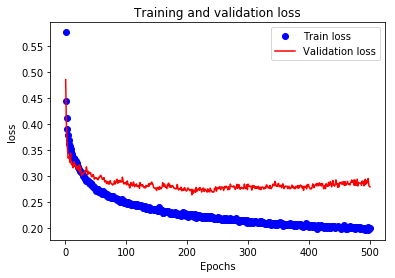

In [51]:
history = model.history.history
plot_epochs_graph(history, 'loss', True)

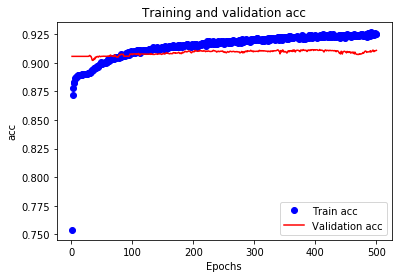

In [52]:
plot_epochs_graph(history, 'acc', True)

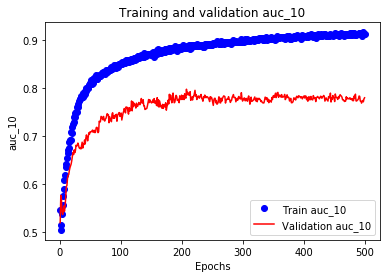

In [53]:
plot_epochs_graph(history, 'auc_10', True)

In [54]:
y_scores = model.predict(X_test.reshape(11518,1,35))

In [55]:
y_scores = y_scores.flatten()

In [56]:
X_test.shape

(11518, 35)

In [57]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc=roc_auc_score(y_test, y_scores)
print("AUC {:.3f}".format(auc))

AUC 0.796
